In [1]:
#------ manually fix import for now
import sys
sys.path.append('..')
#------

import numpy as np
import astropy.units as u
from redexo import *
import matplotlib.pyplot as plt
import copy

Loading 44 files...


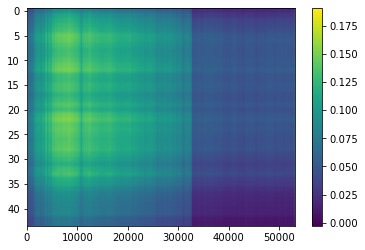

In [2]:
dataset = load_carmenes_data(folder='/users/ricolandman/Documents/Research/OH_exoplanets/Data/Wasp76_NIR/',\
                            spectral_orders=[0,1,2,3,4,5,6,7,23,24,25,26,27])

plt.imshow(dataset.spec.reshape(dataset.num_exposures,-1),aspect='auto')
plt.colorbar()
plt.show()

In [3]:
planet = Planet(Kp=196, vsys=-1.1, T0=2458080.626165, orbital_period=1.809886)
planet.transit_start = 0.045

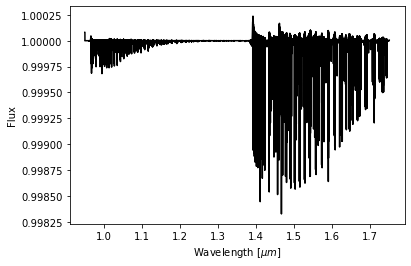

In [4]:
template_wl, template = np.load('/users/ricolandman/Documents/Research/OH_exoplanets/Data/models/Wasp76_OH_equilibrium_T=2150K_prepared.npy')
plt.plot(template_wl/1e4, template, color='black')
plt.xlabel(r'Wavelength [$\mu m$]')
plt.ylabel('Flux')
plt.show()

In [5]:
pipeline = Pipeline()

inject_planet = copy.deepcopy(planet)
inject_planet.vsys = +50

pipeline.add_module( InjectSignalModule(template=template, template_wl=template_wl, 
                                        target=inject_planet, name='injection', amplification=3.) )
pipeline.add_module( FlagAbsorptionEmissionModule(flux_lower_limit=0.4, flux_upper_limit=1.1, 
                                                    relative_to_continuum=True) )

pipeline.add_module( PolynomialContinuumRemovalModule(poly_order=3, name='cleaned'))
pipeline.add_module( OutlierFlaggingModule(sigma=5, name='cleaned') )


sysrem = SysRemModule(number_of_modes=6, mode='subtract', name='sysrem') 
#sysrem = PCASubtractModule(number_of_modes=6,name='sysrem') 
pipeline.add_module(sysrem)

pipeline.add_module( CrossCorrelationModule(template = template, template_wl = template_wl, 
                                            rv_range=300, drv=1.3, error_weighted=True))
#pipeline.add_module( CoAddOrders(name='co_added', weights=None))
pipeline.add_module( ShiftRestFrameModule(target=inject_planet, name='CCF_map_planet'))
pipeline.add_module( CoAddExposures(name='1D_CCF', weights=planet.in_transit(dataset.obstimes)))

In [6]:
pipeline2 = Pipeline()

pipeline2.add_module( FlagAbsorptionEmissionModule(flux_lower_limit=0.4, flux_upper_limit=1.1, 
                                                    relative_to_continuum=True) )

pipeline2.add_module( PolynomialContinuumRemovalModule(poly_order=3, name='cleaned'))
pipeline2.add_module( OutlierFlaggingModule(sigma=5, name='cleaned') )


sysrem2 = SysRemModule(number_of_modes=6, mode='subtract', name='sysrem') 
#sysrem = PCASubtractModule(number_of_modes=6,name='sysrem') 
pipeline2.add_module(sysrem)

pipeline2.add_module( CrossCorrelationModule(template = template, template_wl = template_wl, 
                                            rv_range=300, drv=1.3, error_weighted=True))
#pipeline2.add_module( CoAddOrders(name='co_added', weights=None))
pipeline2.add_module( ShiftRestFrameModule(target=planet, name='CCF_map_planet'))
pipeline2.add_module( CoAddExposures(name='1D_CCF', weights=planet.in_transit(dataset.obstimes)))

In [8]:
snrs = []
snrs_true = []
pipeline.run(dataset, end='cleaned')
pipeline2.run(dataset, end='cleaned')
sysrem_modes = np.arange(1,10)
for sysrem_it in sysrem_modes:
    sysrem.number_of_modes = sysrem_it
    sysrem2.number_of_modes = sysrem
    pipeline.run(copy.deepcopy(dataset), num_workers=7, per_order=True, start='sysrem')
    #pipeline2.run(copy.deepcopy(dataset),num_workers=7, per_order=True, start='sysrem')
    
    ccf_inj = pipeline.get_results('1D_CCF').normalize().spec
    snr_inj = ccf_inj[0,:, ccf_inj.shape[-1]//2]
    snrs.append(snr_inj)
    
    #ccf_map_earth = pipeline2.get_results('co_added')
    #Kp_list = np.arange(100, 300,1.3)
    #snr_map = make_kp_vsys_map(ccf_map_earth, Kp_list, planet)
    '''
    plt.imshow(snr_map,aspect='auto',origin='lower', extent=[np.min(ccf_map_earth.rv_grid), 
                            np.max(ccf_map_earth.rv_grid), min(Kp_list), max(Kp_list)], cmap='gist_heat')
    plt.colorbar()
    plt.show()
    plt.imshow(snr_map[:,np.abs(ccf_map_earth.rv_grid[0,0])<50],aspect='auto',origin='lower', extent=[-50,50,
                                                                min(Kp_list), max(Kp_list)], cmap='gist_heat')
    plt.colorbar()
    plt.show()
    '''
    
    #snr = np.max(snr_map[:,np.abs(ccf_map_earth.rv_grid[0,0])<50])
    #snrs_true.append(snr)
    print('Sysrem iterations:',sysrem_it,snrs[-1])
    

Sysrem iterations: 1 [-0.46226699 -1.77134462 -0.09514949  0.44916857 -0.96820741  0.12428365
  1.3281198  -1.65225361  3.64999384  5.07223445  4.33464947  2.60616505
  2.33190005]
Sysrem iterations: 2 [ 1.85791972  1.45650083 -0.2074995  -0.317047   -0.97180265 -0.26249902
  1.46582667  1.83035904  6.76751596  6.63188868  4.98145896  4.28166849
  1.62634448]
Sysrem iterations: 3 [ 1.27366971  1.1468326   0.29665134  0.07462713 -0.12709486  0.44209573
  1.43457831  1.99329306  6.49743586  8.46385059  5.2869278   4.95385303
  2.25922376]
Sysrem iterations: 4 [ 1.00459677  1.0851338  -0.72426663  0.02075019  0.30147066  0.48780016
  1.29732907  1.79676425  6.35670145  8.47264752  5.5267261   5.35541737
  1.85320735]
Sysrem iterations: 5 [0.52114208 0.1671035  0.30324759 0.48035295 0.46362147 1.98530762
 1.23397695 2.08220547 5.73913129 7.50835539 5.06027719 5.50661089
 1.95340524]
Sysrem iterations: 6 [7.19797517e-01 2.36794684e-01 9.42804392e-01 1.90899592e-03
 3.78538443e-01 5.17667501

(9, 13)
[2 2 6 5 5 5 6 5 2 4 4 5 1]


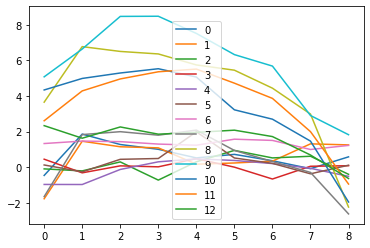

In [9]:
snrs = np.array(snrs)
print(snrs.shape)
for i,snr in enumerate(snrs.T):
    plt.plot(snr, label=i)
optimal_modes = sysrem_modes[np.argmax(snrs,axis=0)]
print(optimal_modes)
plt.legend()

In [35]:
pipeline2 = Pipeline()

pipeline2.add_module( FlagAbsorptionEmissionModule(flux_lower_limit=0.4, flux_upper_limit=1.1, 
                                                    relative_to_continuum=True) )

pipeline2.add_module( PolynomialContinuumRemovalModule(poly_order=3))
pipeline.add_module( OutlierFlaggingModule(sigma=5) )

pipeline2.add_module(SysRemModule(number_of_modes=9, mode='subtract', name='cleaned') )

pipeline2.add_module( CrossCorrelationModule(template = template, template_wl = template_wl, 
                                            rv_range=300, drv=1.3, error_weighted=False))
pipeline2.add_module( CoAddOrders(name='co_added', weights=None))
pipeline2.add_module( ShiftRestFrameModule(target=planet, name='CCF_map_planet'))
pipeline2.add_module( CoAddExposures(name='1D_CCF', weights=planet.in_transit(dataset.obstimes)))

(44, 1, 462)
SNR: 4.523830928567652


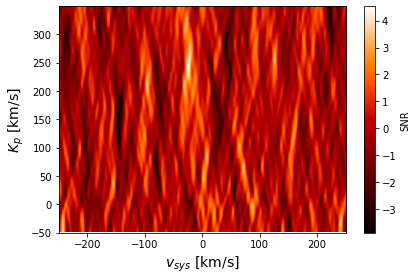

In [36]:
Kp_list = np.arange(-50,350, 1.3)
pipeline2.run(dataset, num_workers=7, per_order=True)
ccf_map_earth = pipeline2.get_results('co_added')

print(ccf_map_earth.spec.shape)
snr_map = make_kp_vsys_map(ccf_map_earth, Kp_list, planet)

plt.imshow(snr_map, origin='lower', cmap='gist_heat', aspect='auto', 
           extent=[np.min(ccf_map_earth.rv_grid), np.max(ccf_map_earth.rv_grid), min(Kp_list), max(Kp_list)])
plt.ylabel(r'$K_p$ [km/s]', fontsize=14)
plt.xlabel(r'$v_{sys}$ [km/s]',fontsize=14)
plt.xlim(-250,250)
plt.colorbar(label='SNR')
plt.tight_layout()
print('SNR:', np.max(snr_map))